# Loading in the Active Learning functions

In [6]:
import numpy as np
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd, 'CustomFunctions'))
from ActiveLearning import *
os.chdir(cwd)

# Load in the data

In [7]:
# Use the same data as question 2.
filepath = "hw4_ex2_data.csv"

data = []
with open(filepath) as f:
    header = f.readline().strip().split(',')
    print('Header Categories:', end = " ")
    for i, category in enumerate(header): print(f"col {i}: {category}    ", end = "")
    for line in f:
        line = line.strip().split(',')
        line = [float(x) for x in line]
        data.append(line)
data = np.array(data)
x = data[:, :2]
y = data[:, 2]
cost = data[:, 3]
print(f'\nThe shape of the data is: {data.shape}\nFeature shape: {x.shape}\nLabel shape: {y.shape}')
print(f'Number of unique classes {len(np.unique(y))}')

Header Categories: col 0: x1    col 1: x2    col 2: y    col 3: cost    col 4: ignore this!    
The shape of the data is: (200, 5)
Feature shape: (200, 2)
Label shape: (200,)
Number of unique classes 3


# Variable Cost Oracle

In [3]:
import multiprocessing as mp
from sklearn.base import clone
from sklearn.svm import SVC

num_simulations = 10 # Number of simulations
batch_size = 1
results = []
with mp.Pool(mp.cpu_count()-1) as p:
    clf = SVC()
    results = []
    for i in range(num_simulations):
        p.apply_async(SimulateAL,
                    kwds= {'x':x, 'y':y, 'cost':cost, 'method':'VCUS', 'seed':i*2024,
                        'clf':clone(clf), 'stratify_data':y,
                        'init_frac':5/x.shape[0], 'end_frac':1,
                        'budget': 500, 'logging_func':TestLog, 'batch_size':batch_size},
                    callback=lambda res: results.append(res))
    p.close()
    p.join()

In [4]:
# Padding the results list so each simulation has the same number of elements.
max_len = 0
for i in range(len(results)):
    if len(results[i]) > max_len: max_len = len(results[i])

for i in range(len(results)):
    if len(results[i]) < max_len:
        num_pad = max_len - len(results[i])
        for _ in range(num_pad):
            results[i].append([np.nan, np.nan])

In [5]:
save = True
filepath = 'results/VCUS_accuracy.npy'
if save:  
    np.save(filepath, np.array(results).squeeze())

# Lowest Cost

In [6]:
import multiprocessing as mp
from sklearn.base import clone
from sklearn.svm import SVC

num_simulations = 10 # Number of simulations
batch_size = 1
results = []
with mp.Pool(mp.cpu_count()-1) as p:
    clf = SVC()
    results = []
    for i in range(num_simulations):
        p.apply_async(SimulateAL,
                    kwds= {'x':x, 'y':y, 'cost':cost, 'method':'LC', 'seed':i*2024,
                        'clf':clone(clf), 'stratify_data':y,
                        'init_frac':5/x.shape[0], 'end_frac':1,
                        'budget': 500, 'logging_func':TestLog, 'batch_size':batch_size},
                    callback=lambda res: results.append(res))
    p.close()
    p.join()

In [7]:
# Padding the results list so each simulation has the same number of elements.
max_len = 0
for i in range(len(results)):
    if len(results[i]) > max_len: max_len = len(results[i])

for i in range(len(results)):
    if len(results[i]) < max_len:
        num_pad = max_len - len(results[i])
        for _ in range(num_pad):
            results[i].append([np.nan, np.nan])

In [8]:
save = True
filepath = 'results/LC_accuracy.npy'
if save:  
    np.save(filepath, np.array(results).squeeze())

# Random Cost

In [9]:
import multiprocessing as mp
from sklearn.base import clone
from sklearn.svm import SVC

num_simulations = 10 # Number of simulations
batch_size = 1
results = []
with mp.Pool(mp.cpu_count()-1) as p:
    clf = SVC()
    results = []
    for i in range(num_simulations):
        p.apply_async(SimulateAL,
                    kwds= {'x':x, 'y':y, 'cost':cost, 'method':'RC', 'seed':i*2024,
                        'clf':clone(clf), 'stratify_data':y,
                        'init_frac':5/x.shape[0], 'end_frac':1,
                        'budget': 500, 'logging_func':TestLog, 'batch_size':batch_size},
                    callback=lambda res: results.append(res))
    p.close()
    p.join()

In [10]:
# Padding the results list so each simulation has the same number of elements.
max_len = 0
for i in range(len(results)):
    if len(results[i]) > max_len: max_len = len(results[i])

for i in range(len(results)):
    if len(results[i]) < max_len:
        num_pad = max_len - len(results[i])
        for _ in range(num_pad):
            results[i].append([np.nan, np.nan])

In [11]:
save = True
filepath = 'results/RC_accuracy.npy'
if save:  
    np.save(filepath, np.array(results).squeeze())

# Plot Results

In [51]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def CostDataPrep(rawdata):
    data, spent = rawdata[:, :, 0], rawdata[:, :, 1]
    mask = ~np.isnan(spent)
    data, spent= data[mask], spent[mask]

    n_bins = rawdata.shape[1]
    clf = KMeans(n_bins, n_init = 50)
    clf.fit(spent.reshape(-1, 1))
    bin_assignments = clf.predict(spent.reshape(-1,1))
    sorted_clusters = sorted(zip(clf.cluster_centers_, np.arange(n_bins)), key = lambda l: l[0])
    sorted_clusters = {tup[1]:i for i, tup in enumerate(sorted_clusters)}
    bin_assignments = [sorted_clusters[idx] for idx in bin_assignments]

    x = [[] for _ in range(n_bins)]
    y = [[] for _ in range(n_bins)]
    for acc, cost, idx in zip(data, spent, bin_assignments):
        x[idx].append(cost)
        y[idx].append(acc)
    
    return x, y
        
def PlotData(filepath, label, fig, ax):
    data = np.load(filepath)
    x_bin, y_bin = CostDataPrep(data)
    x = [np.mean(lst) for lst in x_bin]
    y = [np.mean(lst) for lst in y_bin]
    y_std = [np.std(lst) for lst in y_bin]  

    handle, = ax.plot(x,y, label = label)
    color = handle.get_color()
    ax.errorbar(x, y, y_std, color = color, linestyle = '', capsize=5, alpha = 0.2)


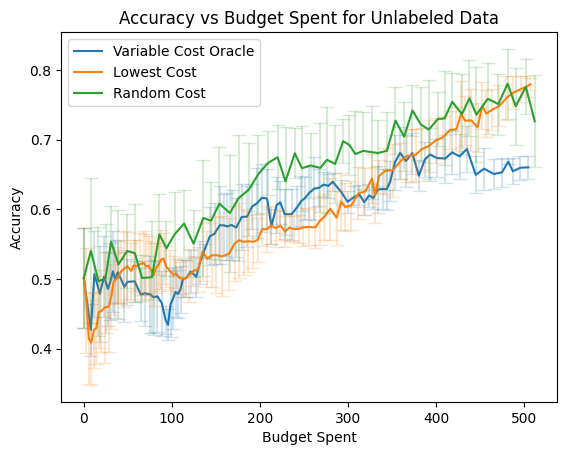

In [52]:
filepaths = ['results/VCUS_accuracy.npy', 'results/LC_accuracy.npy', 'results/RC_accuracy.npy']
labels = ['Variable Cost Oracle', 'Lowest Cost', 'Random Cost']
batch_size = 3
fig, ax = plt.subplots()

for i in range(len(labels)):
    PlotData(filepaths[i], labels[i], fig, ax)
ax.legend()
ax.set_title('Accuracy vs Budget Spent for Unlabeled Data')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Budget Spent')
plt.show(fig)